In [10]:
import numpy as np

if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_

import gym
import imageio
from IPython.display import Image

gif_path = "cartpole.gif"

env = gym.make('CartPole-v1', render_mode="rgb_array")
state = env.reset()
print(state)

action_space = env.action_space
print(action_space)

(array([ 0.02241998,  0.01586274, -0.02912379, -0.04567677], dtype=float32), {})
Discrete(2)


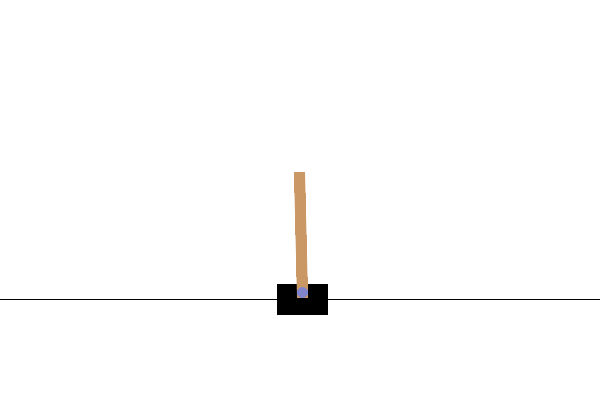

In [11]:
frames = []
frames.append(env.render())

action = 0
obs, reward, terminated, truncated, _ = env.step(action)
frames.append(env.render())

imageio.mimsave(gif_path, frames, fps=30)
Image(filename=gif_path)

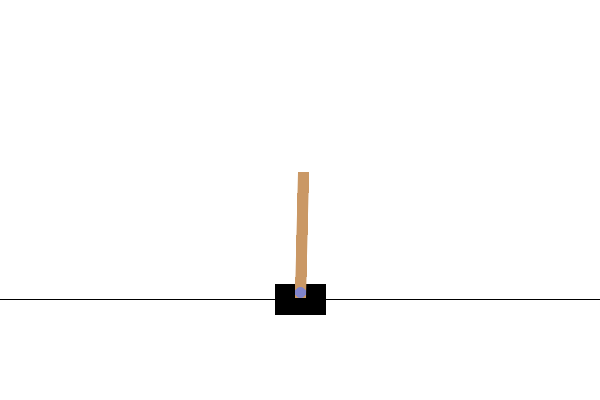

In [12]:
env = gym.make('CartPole-v1', render_mode='rgb_array')
state, _ = env.reset()

frames = []

while True:
    frames.append(env.render())
    action = np.random.choice([0, 1])
    state, reward, terminated, _, info = env.step(action)
    if terminated:
        break
env.close()

imageio.mimsave(gif_path, frames, fps=30)
Image(filename=gif_path)

In [13]:
from collections import deque
import random
import numpy as np


class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)
        self.buffer.append(data)

    def __len__(self):
        return len(self.buffer)

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)

        state = np.stack([x[0] for x in data])
        action = np.array([x[1] for x in data])
        reward = np.array([x[2] for x in data])
        next_state = np.stack([x[3] for x in data])
        done = np.array([x[4] for x in data]).astype(np.int32)
        return state, action, reward, next_state, done

In [14]:
import gym

env = gym.make('CartPole-v1')
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)

for episode in range(10):
    state, _ = env.reset()
    done = False
    while not done:
        action = 0
        next_state, reward, done, _, _ = env.step(action)
        replay_buffer.add(state, action, reward, next_state, done)
        state = next_state

state, action, reward, next_state, done = replay_buffer.get_batch()
print(state.shape)
print(action.shape)
print(reward.shape)
print(next_state.shape)
print(done.shape)

(32, 4)
(32,)
(32,)
(32, 4)
(32,)


In [15]:
import copy
from dezero import Model, optimizers
import dezero.functions as F
import dezero.layers as L


class QNet(Model):
    def __init__(self, action_size):
        super().__init__()
        self.l1 = L.Linear(128)
        self.l2 = L.Linear(128)
        self.l3 = L.Linear(action_size)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        return self.l3(x)


class DQNAgent:
    def __init__(self):
        self.gamma = 0.98
        self.lr = 0.0005
        self.epsilon = 0.1
        self.buffer_size = 10000
        self.batch_size = 32
        self.action_size = 2
        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)
        self.qnet = QNet(self.action_size)
        self.qnet_target = QNet(self.action_size)
        self.optimizer = optimizers.Adam(self.lr)
        self.optimizer.setup(self.qnet)

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            state = state.reshape(1, -1)
            qs = self.qnet(state)
            return qs.data.argmax()

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)
        if len(self.replay_buffer) < self.batch_size:
            return
        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)
        q = qs[np.arange(self.batch_size), action]

        next_qs = self.qnet_target(next_state)
        next_q = next_qs.max(axis=1)
        next_q.unchain()
        target = reward + (1 - done) * self.gamma * next_q

        loss = F.mean_squared_error(q, target)

        self.qnet.cleargrads()
        loss.backward()
        self.optimizer.update()

In [18]:
episodes = 300
sync_interval = 20
env = gym.make('CartPole-v1', render_mode="rgb_array")
agent = DQNAgent()
reward_history = []

for episode in range(episodes):
    state, _ = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        action = agent.get_action(state)
        next_state, reward, done , _, _=env.step(action)
        
        agent.update(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
    
    print(episode,total_reward)
    if episode % sync_interval == 0:
        agent.sync_qnet()
        
    reward_history.append(total_reward)

0 18.0
1 10.0
2 10.0
3 11.0
4 12.0
5 10.0
6 11.0
7 9.0
8 10.0
9 10.0
10 11.0
11 11.0
12 10.0
13 13.0
14 10.0
15 16.0
16 10.0
17 13.0
18 11.0
19 10.0
20 11.0
21 11.0
22 9.0
23 10.0
24 10.0
25 9.0
26 10.0
27 11.0
28 11.0
29 11.0
30 11.0
31 9.0
32 10.0
33 9.0
34 10.0
35 9.0
36 9.0
37 11.0
38 12.0
39 10.0
40 11.0
41 9.0
42 10.0
43 11.0
44 9.0
45 9.0
46 9.0
47 9.0
48 10.0
49 9.0
50 10.0
51 9.0
52 9.0
53 8.0
54 9.0
55 9.0
56 9.0
57 11.0
58 10.0
59 14.0
60 11.0
61 10.0
62 9.0
63 8.0
64 11.0
65 10.0
66 10.0
67 11.0
68 8.0
69 9.0
70 9.0
71 9.0
72 11.0
73 9.0
74 8.0
75 9.0
76 11.0
77 8.0
78 9.0
79 10.0
80 10.0
81 10.0
82 10.0
83 10.0
84 10.0
85 14.0
86 12.0
87 11.0
88 12.0
89 9.0
90 11.0
91 12.0
92 13.0
93 10.0
94 9.0
95 10.0
96 9.0
97 12.0
98 9.0
99 12.0
100 9.0
101 10.0
102 12.0
103 13.0
104 9.0
105 9.0
106 14.0
107 9.0
108 10.0
109 10.0
110 11.0
111 11.0
112 9.0
113 10.0
114 10.0
115 10.0
116 10.0
117 9.0
118 16.0
119 13.0
120 8.0
121 14.0
122 14.0
123 16.0
124 14.0
125 25.0
126 20.0
127 27.0

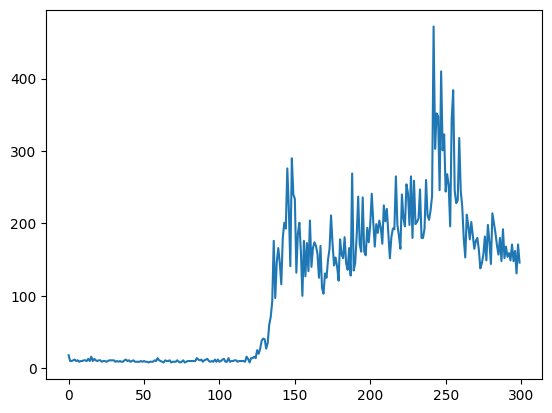

In [19]:
import matplotlib.pyplot as plt
plt.plot(reward_history)
plt.show()

Total Reward 171.0


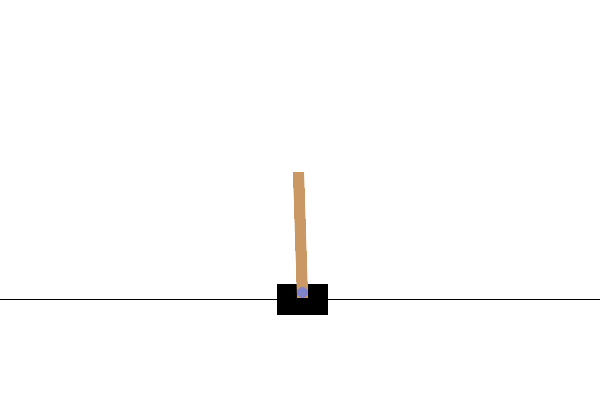

In [21]:
agent.epsilon = 0
state,_ = env.reset()
done = False
total_reward = 0

frames = []

while not done:
    action = agent.get_action(state)
    next_state, reward, done , _, _=env.step(action)
    state = next_state
    total_reward += reward
    frames.append(env.render())
print('Total Reward', total_reward)
imageio.mimsave(gif_path, frames, fps=30)
Image(filename=gif_path)